# Training a Diabetes Regression Model In Notebook

In [1]:
%matplotlib inline
import azureml.core
from azureml.core import Experiment, Workspace
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [4]:
DATA_PATH = "../../data/"

ws = Workspace.from_config()
print()
print(f'Workspace name:\t{ws.name}', 
      f'Azure region:\t{ws.location}',
      f'Subscription:\t{ws.subscription_id}',
      f'Resource group:\t{ws.resource_group}',
      sep='\n')

Found the config file in: C:\Users\erikzwi\Projects\AML-Demo-Diabetes\code\aml_config\config.json

Workspace name:	azureml_ws
Azure region:	eastus
Subscription:	02559c12-8982-43b3-8180-f4e41779489b
Resource group:	azureml_demos


---

## Data
We will use the diabetes dataset for this experiement, a well-known small dataset that comes with scikit-learn.  This cell loads the dataset and splits it into random training and testing sets.


In [32]:
from sklearn.datasets import load_diabetes
print(load_diabetes()['DESCR'])

Diabetes dataset

Notes
-----

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

Data Set Characteristics:

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attributes:
    :Age:
    :Sex:
    :Body mass index:
    :Average blood pressure:
    :S1:
    :S2:
    :S3:
    :S4:
    :S5:
    :S6:

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani

In [21]:
diabetes_df = pd.read_csv(os.path.join(DATA_PATH,"diabetes.csv"))

diabetes_df.head(5)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [5]:
y = diabetes_df.pop('target').values
X = diabetes_df.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print (f"Data contains {len(X_train)} training samples and {len(X_test)} test samples")

Data contains 353 training samples and 89 test samples


---
## Train

Let's use scikit-learn to train a simple Ridge regression model.  We use AML to record interesting information about the model in an Experiment.  An Experiment contains a series of trials called Runs.  During this trial we use AML in the following way:
* We access an experiment from our AML workspace by name, which will be created if it doesn't exist
* We use `start_logging` to create a new run in this experiment
* We use `run.log()` to record a parameter, alpha, and an accuracy measure - the Mean Squared Error (MSE) to the run.  We will be able to review and compare these measures in the Azure Portal at a later time.
* We store the resulting model in the **outputs** directory, which is automatically captured by AML when the run is complete.
* We use `run.complete()` to indicate that the run is over and results can be captured and finalized

In [6]:
def plot_residuals(y, y_hat):
    resids = y - y_hat
    
    fig = plt.figure()
    sns.regplot(y, resids)
    
    plt.xlabel("Actual Value")
    plt.ylabel("Residuals")
    
    plt.close(fig)
    return fig

In [7]:
experiment_name = 'diabetes_regression'
experiment = Experiment(workspace=ws, name=experiment_name)

RMSE:	58.5226
MAE:	46.0835
R2:	0.3321


C:\Users\erikzwi\AppData\Roaming\Python\Python36\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


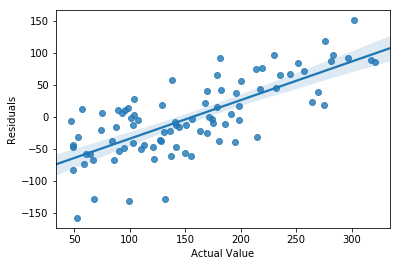

In [8]:
# Create a run object in the experiment
with experiment.start_logging() as run:
    # Log the algorithm parameter alpha to the run
    alpha = 0.03
    run.log('alpha', alpha)
    run.log('model_type', 'Ridge')
    
    # Create, fit, and test the scikit-learn Ridge regression model
    regression_model = Ridge(alpha=alpha)
    regression_model.fit(X_train, y_train)
    preds = regression_model.predict(X_test)

    # Output the Mean Squared Error to the notebook and to the run
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    print(f"RMSE:\t{np.round(rmse,4)}",
          f"MAE:\t{np.round(mae,4)}",
          f"R2:\t{np.round(r2,4)}",
          sep='\n')
    
    # Log metrics to Azure ML
    run.log('rmse', rmse)
    run.log('mae', mae)
    run.log('r2', r2)
    
    plt_fig = plot_residuals(y_test, preds)
    
    run.log_image(name='residuals', plot=plt_fig)
    
    # Save the model to the outputs directory for capture
    joblib.dump(value=regression_model, filename='outputs/model.pkl')
    
plt_fig

In [28]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
diabetes_regression,4b0b499f-eda7-45a2-8c6f-8b5a7362c01d,,Completed,Link to Azure Portal,Link to Documentation


In [9]:
# If we encapsulate the logic in a function, we can do a *simple* Hyperparameter sweep with a loop
def train_ridge_regression(run, X_train, y_train, X_test, y_test, alpha=0.03, model_filename='model.pkl', show_output=False):
    # Log the algorithm parameter alpha to the run
    run.log('alpha', alpha)
    run.log('model_type', 'Ridge')
    
    # Create, fit, and test the scikit-learn Ridge regression model
    regression_model = Ridge(alpha=alpha)
    regression_model.fit(X_train, y_train)
    preds = regression_model.predict(X_test)

    # Output the Mean Squared Error to the notebook and to the run
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    
    if show_output:
        print(f"RMSE:\t{np.round(rmse,4)}",
              f"MAE:\t{np.round(mae,4)}",
              f"R2:\t{np.round(r2,4)}",
              sep='\n')
    
    # Log metrics to Azure ML
    run.log('rmse', rmse)
    run.log('mae', mae)
    run.log('r2', r2)
    
    plt_fig = plot_residuals(y_test, preds)
    
    run.log_image(name='residuals', plot=plt_fig)
    
    # Save the model to the outputs directory for capture
    joblib.dump(value=regression_model, filename=f'outputs/{model_filename}')
    
    return plt_fig

### Simple parameter sweep
Now let's take the same concept from above and modify the **alpha** parameter.  For each value of alpha we will create a run that will store metrics and the resulting model.  In the end we can use the captured run history to determine which model was the best for us to deploy. 

Note that by using `with experiment.start_logging() as run` AML will automatically call `run.complete()` at the end of each loop.

This example also uses the **tqdm** library to provide a status bar feedback

In [10]:
import numpy as np
from tqdm import tqdm

model_name = "model.pkl"

# list of numbers from 0 to 1.0 with a 0.05 interval
alphas = np.arange(0.0, 1.0, 0.05)

# try a bunch of alpha values in a Linear Regression (Ridge) model
for alpha in tqdm(alphas):
    # create a bunch of runs, each train a model with a different alpha value
    with experiment.start_logging() as run:
        train_ridge_regression(run, X_train, y_train, X_test, y_test, alpha, model_name)


100%|██████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:03<00:00,  6.04s/it]


### Viewing experiment results
Similar to viewing the run, we can also view the entire experiment.  The experiment report view in the Azure portal lets us view all the runs in a table, and also allows us to customize charts.  This way, we can see how the alpha parameter impacts the quality of the model

In [11]:
# now let's take a look at the experiment in Azure portal.
experiment

Name,Workspace,Report Page,Docs Page
diabetes_regression,azureml_ws,Link to Azure Portal,Link to Documentation


# Your Turn
Repeat the above steps with another sklearn algorithm. 

Hint: Check out [Scikit-Learn.ensemble](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble) or [Scikit-Learn.linear_model](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model) for other algorithm to try.

In [ ]:
def your_algo_name_here():
    raise NotImplementedError

### Select the best model 
Now that we've created many runs with different parameters, we need to determine which model is the best for deployment.  For this, we will iterate over the set of runs.  From each run we will take the *run id* using the `id` property, and examine the metrics by calling `run.get_metrics()`.  

Since each run may be different, we do need to check if the run has the metric that we are looking for, in this case, **mse**.  To find the best run, we create a dictionary mapping the run id's to the metrics.

Finally, we use the `tag` method to mark the best run to make it easier to find later. 

In [10]:
runs = {}
run_metrics = {}

# Create dictionaries containing the runs and the metrics for all runs containing the 'mse' metric
for r in tqdm(experiment.get_runs()):
    metrics = r.get_metrics()
    if 'rmse' in metrics.keys():
        runs[r.id] = r
        run_metrics[r.id] = metrics

# Find the run with the best (lowest) mean squared error and display the id and metrics
best_run_id = min(run_metrics, key = lambda k: run_metrics[k]['rmse'])
best_run = runs[best_run_id]
print('Best run is:', best_run_id)
print('Metrics:', run_metrics[best_run_id])

# Tag the best run for identification later
best_run.tag("Best Run")

122it [00:37,  3.36it/s]


Best run is: e294dc51-6411-423c-95ce-43e4d35a9eb5
Metrics: {'alpha': 0.4, 'model_type': 'Ridge', 'rmse': 57.40854522068826, 'mae': 45.33695466739181, 'r2': 0.3572956390661659, 'residuals': 'aml://artifactId/residuals.png'}


---
## Deploy
Now that we have trained a set of models and identified the run containing the best model, we want to deploy the model for real time inferencing.  The process of deploying a model involves
* registering a model in your workspace
* creating a scoring file containing init and run methods
* creating an environment dependency file describing packages necessary for your scoring file
* creating a docker image containing a properly described environment, your model, and your scoring file
* deploying that docker image as a web service

### Register a model
We have already identified which run contains the "best model" by our evaluation criteria.  Each run has a file structure associated with it that contains various files collected during the run.  Since a run can have many outputs we need to tell AML which file from those outputs represents the model that we want to use for our deployment.  We can use the `run.get_file_names()` method to list the files associated with the run, and then use the `run.register_model()` method to place the model in the workspace's model registry.

When using `run.register_model()` we supply a `model_name` that is meaningful for our scenario and the `model_path` of the model relative to the run.  In this case, the model path is what is returned from `run.get_file_names()`

In [11]:
# View the files in the run
for f in best_run.get_file_names():
    print(f)
    
# Register the model with the workspace
model = best_run.register_model(model_name='diabetes_regression_model', model_path='outputs/model.pkl')

outputs/model.pkl
residuals.png


Once a model is registered, it is accessible from the list of models on the AML workspace.  If you register models with the same name multiple times, AML keeps a version history of those models for you.  The `Model.list()` lists all models in a workspace, and can be filtered by name, tags, or model properties.   

In [12]:
# Find all models called "best_model" and display their version numbers
from azureml.core.model import Model
models = Model.list(ws, name='diabetes_regression_model')
for m in models:
    print(m.name, m.version)

diabetes_regression_model 4
diabetes_regression_model 3
diabetes_regression_model 2
diabetes_regression_model 1


### Create a scoring file

In [13]:
%%writefile score.py
import pickle
import json
import numpy as np
from sklearn.externals import joblib
from sklearn.linear_model import Ridge
from azureml.core.model import Model


def init():
    global model
    # note here "best_model" is the name of the model registered under the workspace
    # this call should return the path to the model.pkl file on the local disk.
    model_path = Model.get_model_path(model_name='diabetes_regression_model')
    # deserialize the model file back into a sklearn model
    model = joblib.load(model_path)


# note you can pass in multiple rows for scoring
def run(raw_data):
    try:
        data = json.loads(raw_data)['data']
        data = np.array(data)
        result = model.predict(data)

        # you can return any data type as long as it is JSON-serializable
        return result.tolist()
    except Exception as e:
        result = str(e)
        return result

Overwriting score.py


### Describe your environment

In [12]:
from azureml.core.conda_dependencies import CondaDependencies 
from azureml.core.image import ContainerImage

conda_file_path = './aml_config/condaEnv.yml'
os.makedirs('./aml_config/')

# Create an empty conda environment and add the scikit-learn package
env = CondaDependencies()
env.add_conda_package("scikit-learn")

# Display the environment
print(env.serialize_to_string())

# Write the environment to disk
with open(conda_file_path,"w") as f:
    f.write(env.serialize_to_string())

# Create a configuration object indicating how our deployment container needs to be created
image_config = ContainerImage.image_configuration(execution_script="score.py", 
                                    runtime="python", 
                                    conda_file=conda_file_path)

# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
    # Required packages for AzureML execution, history, and data preparation.
  - azureml-defaults
- scikit-learn



### Describe your target compute

In [37]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={'disease': 'diabetes', 'target': 'blood_sugar'}, 
                                               description='Diabetes Regression Model')

### Deploy your webservice
**Note:** The web service creation can take several minutes.  

In [38]:
%%time
from azureml.core.webservice import Webservice

# Create the webservice using all of the precreated configurations and our best model
service = Webservice.deploy_from_model(name='diabetes-svc',
                                       deployment_config=aciconfig,
                                       models=[model],
                                       image_config=image_config,
                                       workspace=ws)

# Wait for the service deployment to complete while displaying log output
service.wait_for_deployment(show_output=True)

Creating image
Image creation operation finished for image diabetes-svc:3, operation "Succeeded"
Creating service
Running..................
SucceededACI service creation operation finished, operation "Succeeded"
Wall time: 6min 18s



### Test your webservice

In [39]:
import json
# scrape the first row from the test set.
test_samples = json.dumps({"data": X_test[0:1, :].tolist()})

#score on our service
service.run(input_data = test_samples)

[217.67978776218712]

This cell shows how you can send multiple rows to the webservice at once.  It then calculates the residuals - that is, the errors - by subtracting out the actual values from the results.  These residuals are used later to show a plotted result.

In [40]:
# score the entire test set.
test_samples = json.dumps({'data': X_test.tolist()})

result = service.run(input_data = test_samples)
residual = result - y_test

This cell shows how you can use the `service.scoring_uri` property to access the HTTP endpoint of the service and call it using standard POST operations.

In [41]:
import requests

# use the first row from the test set again
test_samples = json.dumps({"data": X_test[0:1, :].tolist()})

# create the required header
headers = {'Content-Type':'application/json'}

# post the request to the service and display the result
resp = requests.post(service.scoring_uri, test_samples, headers = headers)
print(resp.text)

[217.67978776218712]


### Clean up

Delete the ACI instance to stop the compute and any associated billing.

In [42]:
%%time
service.delete()

Wall time: 1.06 s
